# Workspace \#9: ``model.py``

In [1]:
# getting future division
from __future__ import division

# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

In [3]:
# The contents of model.py
dir(md)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'ap',
 'ct',
 'ec',
 'np',
 'pt',
 'rt',
 'sk',
 'snr_routine']

In [4]:
dt.snrs_cut['G39.7-2.0'].__dict__

{'no_dist': False,
 'no_flux': False,
 'is_complete': False,
 'is_spectral_certain': False,
 'is_flux_certain': False,
 'is_type_certain': False,
 'name': 'G39.7-2.0',
 'l': 39.7,
 'b': -2.0,
 'ang_size': 84.8528137423857,
 'sr': 0.0004784858509023251,
 'snu_at_1GHz': 85.0,
 'alpha': 0.7,
 'distance': 4.9,
 'age': 54772.25575051661,
 'radius': 60.47257332493333}

In [5]:
# defining a test SNR
test_snr = dt.SuperNovaRemnant()
# test_snr.__dict__ = {
#     'age': 35000.,
#     'alpha': 0.7,
#     'gamma': 1.8,
#     'ang_size': 84.8528137423857,
#     'sr': 0.0004784858509023251,
#     'distance': 1.8,
#     'no_dist': False,
#     'l': 39.7,
#     'b': -2.,
#     'name': 'W50',
#     'snu_at_1GHz': 310.0,
#     'no_flux': False,
#     'type': 'S'}

W28 = 'G6.4-0.1'
W50 = 'G39.7-2.0'

test_snr.__dict__ = {key:val for key, val in dt.snrs_dct[W50].__dict__.items()}

alpha = test_snr.get_spectral_index()

if alpha == None:
    alpha = 0.7
    test_snr.__dict__.update({'alpha':alpha})
    

# test_snr.__dict__.update({'age':35000, 'gamma': ap.gamma_from_alpha(alpha)})

# test_snr.__dict__.update({'age':38108.67943347, 'gamma': ap.gamma_from_alpha(alpha)})

test_snr.__dict__.update({'gamma': ap.gamma_from_alpha(alpha)})

../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
../routines.py:395: RuntimeWarning: invalid value encountered in true_divide
  new_output['noise_power']
No handles with labels found to put in legend.


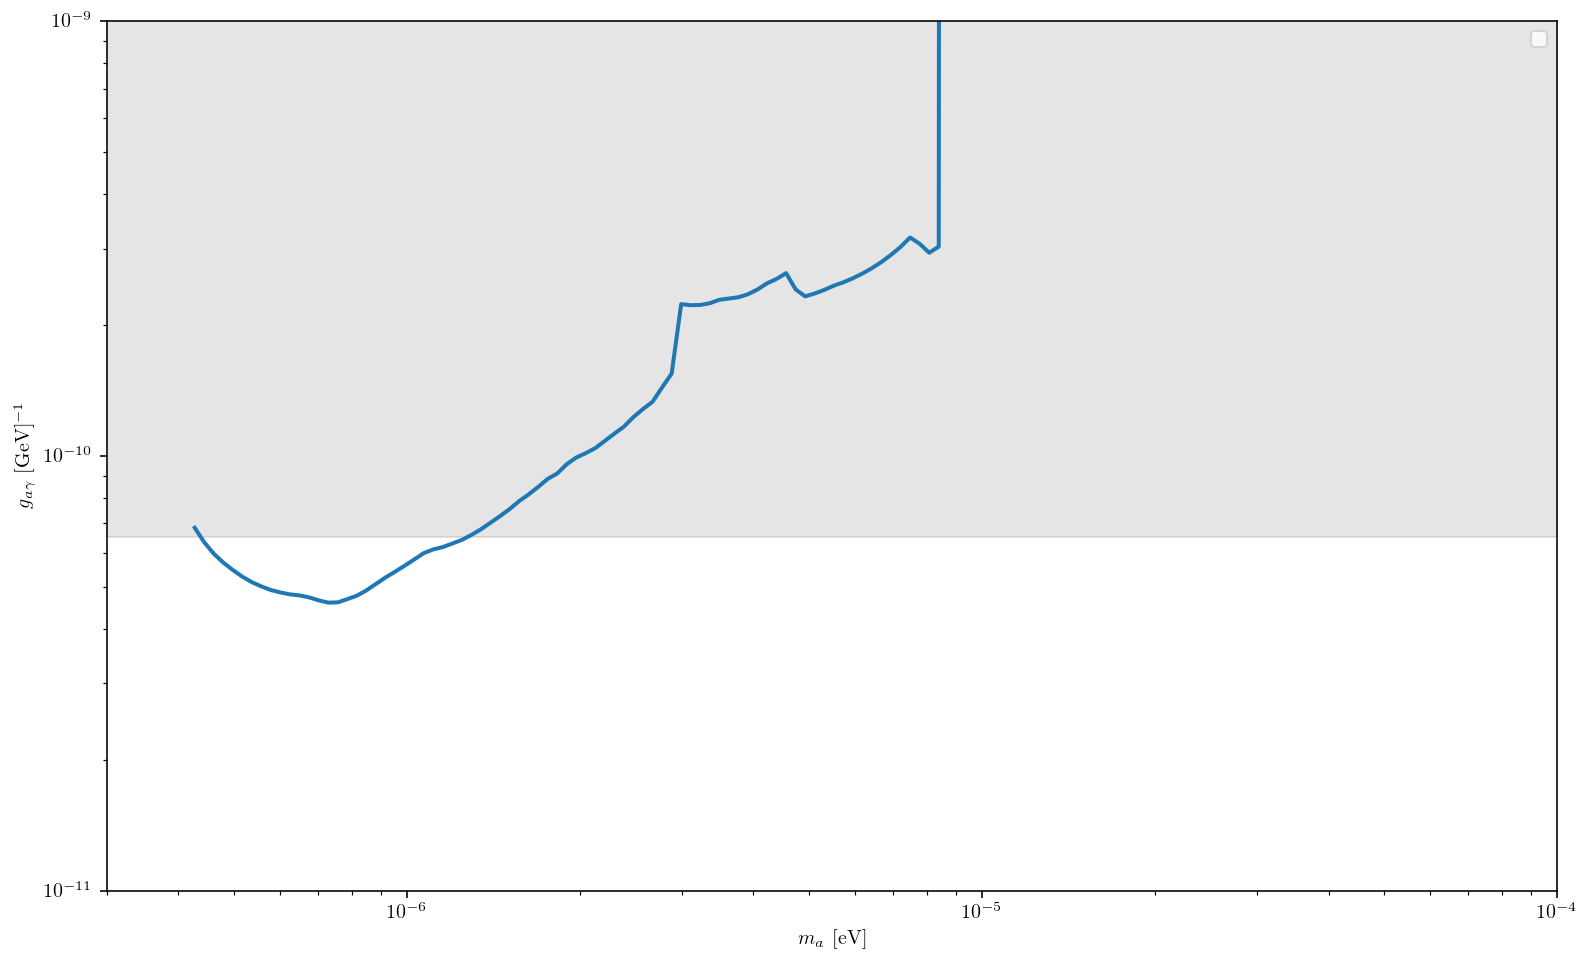

In [6]:
ma_arr = np.logspace(np.log10(1e-7), np.log10(2e-4), 200)
t_age_arr = np.logspace(3, 6, 7)
sig_noi_thres = 1.
ga_ref = 1.e-10 # doesn't matter, will be rescaled

use_free = False

counter = 0
# best_snr = None
# best_ga = 1.# at first ma point

plt.subplots()
#for _, snr in tqdm(snrs_dct.items(), total=len(snrs_dct.keys())):

for snr in [test_snr]:
    
    try:
        distance = snr.get_distance()

    except:
        continue
    
    t_age = snr.get_age()
#     t_age = 30000
        
    snu_echo_kwargs = {'tmin_default':None,
                           'Nt':100000, # for a fine enough array
                           'xmin':ct._au_over_kpc_,
                           'xmax_default':100.,
                           'use_quad':False,
                           'lin_space':False,
                           'Nint':100000, # for a fine enough array
                           't_extra_old':0.
                          }
    # data:
    data = {'deltaE_over_E':ct._deltaE_over_E_,
                'f_Delta':ct._f_Delta_,
                'exp':'SKA',
                'total_observing_time':100.,
                'verbose':0,
                'correlation_mode':'interferometry',
                'average':True
               }
        
    t_trans = 300.
    t_peak = 10.**(ct._mu_log10_tpk_) #* 10.
    
    lightcurve_params = {'t_peak':t_peak,
#                              'L_peak':L_peak,
                             't_age':t_age,
                             't_trans':t_trans,
                             'L_today':snr.get_luminosity(),
                             'use_free_expansion':use_free
                            }
        
    sig_noi = md.snr_routine(ma_arr, ga_ref,
                                 snr,
                                 lightcurve_params=lightcurve_params,
                                 snu_echo_kwargs=snu_echo_kwargs,
                                 data=data,
                                 output_all=False)
        
    ga_arr = ec.ga_reach(sig_noi_thres, sig_noi, ga_ref)
        
    plt.plot(ma_arr, ga_arr, lw='2.', alpha=1.)
    counter += 1

#         if best_ga > ga_arr[0]:
#             best_snr = snr
#             best_ga = ga_arr[0]
    #     if counter == 2:
    #         break

ga_cast = 6.5e-11
plt.fill_between([1e-7, 1e-2], ga_cast, 1, color='grey', alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-9)
plt.xlim(3e-7, 1e-4)
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{a\gamma}$ [GeV]$^{-1}$')
plt.legend(loc='best')


# title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}"
# title = title_str.format(D=snr.distance,
#                          log10Lpk=np.log10(snr.Lpk), 
#                          log10tpk=np.log10(snr.tpk),
#                          ell=snr.l,
#                          b=snr.b,
#                          alpha=snr.alpha,
#                          sn=sig_noi_thres)

# plt.title(title)

# print('ga_arr:',  ga_arr)

### Studying Green's Catalogue

In [7]:
verbose = 2
snr_results = {}

ga_ref = 1.e-10

tpk = 10.**(1.7)
Lpk = 10.**(28.)
t_trans = 100.
# t_trans_over_t_peak = 30.
# t_trans = (tpk/365.)*t_trans_over_t_peak

for name, snr in dt.snrs_age.items():
    
    t_age = snr.get_age()
    
    lightcurve_params = {'t_peak':tpk,
                         't_trans':t_trans,
                         't_age':t_age}
    
    snu_echo_kwargs = {'tmin_default':None,
                       'Nt':int(30001),
                       'xmin':ct._au_over_kpc_,
                       'xmax_default':100.,
                       'use_quad':False,
                       'lin_space':False,
                       'Nint':int(30001),
                       't_extra_old':0.
                      }
    # data:
    data = {'deltaE_over_E':ct._deltaE_over_E_,
            'f_Delta':ct._f_Delta_,
            'exper':'SKA',
            'total_observing_time':100.,
            'verbose':0,
            'correlation_mode':'interferometry',
            'average':True
           }
    
    z, new_output = md.snr_routine(pt.ma_from_nu(1.), ga_ref,
                                   snr,
                                   lightcurve_params=lightcurve_params,
                                   snu_echo_kwargs=snu_echo_kwargs,
                                   data=data,
                                   output_all=True,
                                   verbose=verbose)
    
    snr_results[name] = new_output
    
    # obtaining L_today
    L0 = snr.get_luminosity() # [cgs]

SNR size=6.0e-07. Value will be respected.
signal power:5.806265394835402e-20
noise power:9.92029949697011e-18
s/n: 0.005852913409125168

SNR size=1.1e-06. Value will be respected.
signal power:4.259507574255806e-19
noise power:9.728898045368845e-18
s/n: 0.043782014719369156

SNR size=1.4e-05. Value will be respected.
signal power:1.0578776314873312e-18
noise power:2.141734037572371e-17
s/n: 0.04939351072210733

SNR size=4.3e-06. Value will be respected.
signal power:7.587198986181078e-19
noise power:1.3728442490976773e-17
s/n: 0.055266276499813284

SNR size=1.2e-05. Value will be respected.
signal power:4.6858032710203817e-17
noise power:1.9867418404677013e-17
s/n: 2.358536562514479

SNR size=7.2e-05. Value will be respected.
signal power:1.5583355395665702e-18
noise power:4.541640694190163e-17
s/n: 0.03431217140448938

SNR size=2.7e-05. Value will be respected.
signal power:2.4538180241432213e-17
noise power:2.77358966111339e-17
s/n: 0.8847083829834423

SNR size=4.8e-05. Value will b